# Customer Age Detection

This project tackles age estimation from face images for the retail chain “Bread-Salt”. The goal is to build a computer vision model that predicts a customer’s approximate age from a photo captured at checkout. Such a system helps:

- Understand customer behavior and personalize product recommendations for age cohorts.
- Enforce compliance by monitoring alcohol sales to underage customers.

We approach the task as a regression problem on a labeled dataset of human faces with known ages. The workflow includes:

- Exploratory Data Analysis (EDA): inspecting class balance, age distribution, and missing labels.
- Data preparation & augmentation: rescaling pixel values and light augmentation to improve generalization.

**Modeling:** transfer learning with ResNet50 (ImageNet weights), followed by GlobalAveragePooling and a single Dense(1) output for age.

**Training setup:**  input size 224×224, batch size 16, loss MSE, metric MAE, optimizer Adam (lr=5e-4), with a 25% validation split.

**Result:**  validation MAE ≈ 6.9 years, which is a strong baseline for this dataset and setup.

This repository demonstrates a clean, reproducible pipeline from EDA to a trained model ready for iterative improvements and deployment experiments.

## Exploratory Data Analysis

### Import Libraries and Read CSV Files

In [2]:
# Import Libraries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import random

In [3]:
# Define Data Paths
BASE_DIR = Path('/datasets/faces')
IMG_DIR = BASE_DIR / 'final_files'
LABELS_PATH = BASE_DIR / 'labels.csv'

In [4]:
# Set seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Load Annotations and Basic Checks

In [5]:
# Load annotations
labels = pd.read_csv(LABELS_PATH)

print('Table shape:', labels.shape)
display(labels.head())

Table shape: (7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# Convert data types
labels['file_name'] = labels['file_name'].astype(str)
labels['real_age'] = pd.to_numeric(labels['real_age'], errors='coerce')

In [6]:
# Check for missing values
print('Missing data per column:')
print(labels.isna().sum())

Missing data per column:
file_name    0
real_age     0
dtype: int64


In [7]:
# Check for duplicates
dup_count = labels.duplicated(subset=['file_name']).sum()
print('Duplicates in file_name:', dup_count)

Duplicates in file_name: 0


In [8]:
# Basic Age Statistics
display(labels['real_age'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
5%          5.000000
25%        20.000000
50%        29.000000
75%        41.000000
95%        63.000000
max       100.000000
Name: real_age, dtype: float64

In [8]:
# Check dataset size after cleaning
n_rows = len(labels)
n_unique_files = labels['file_name'].nunique()
print(f'Sample size: {n_rows} records, unique files: {n_unique_files}')

Sample size: 7591 records, unique files: 7591


### Age Distribution

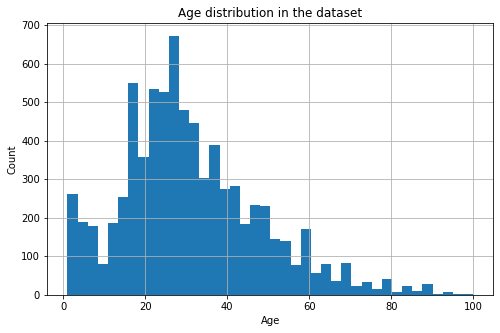

In [9]:
# Plot age histogram
plt.figure(figsize=(8, 5))
labels['real_age'].hist(bins=40)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution in the dataset')
plt.show()

The histogram shows a right-skewed distribution: most observations fall between 18–40 years old, with a peak around 20–30. After approximately 40, the frequency drops rapidly, forming a long tail extending beyond 60+, with a few outliers up to 100. Children (<10) and elderly individuals (>60) are significantly underrepresented — indicating a clear imbalance toward young adults.

### Quick Preview of 10–15 Images

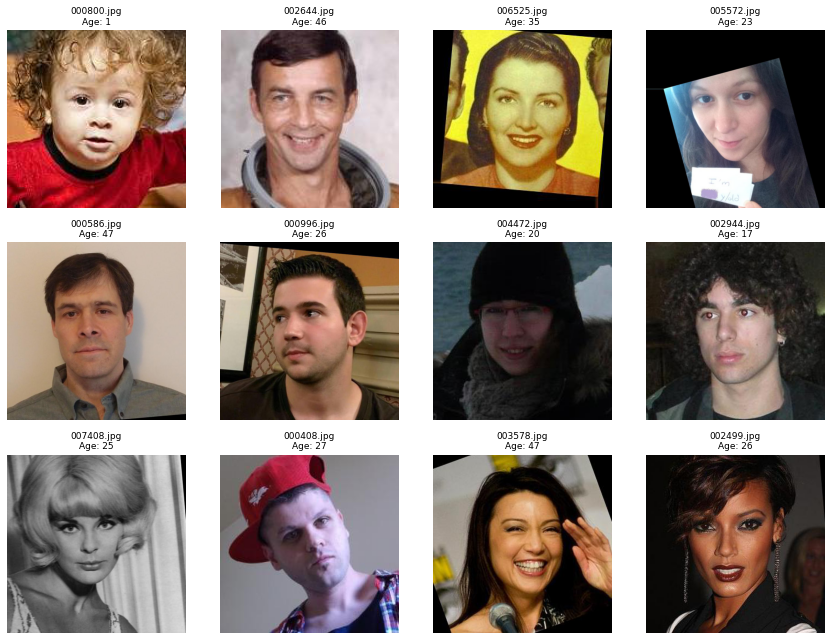

In [10]:
# Preview a few images from the dataset
def show_samples(df, img_dir, n=12, max_cols=4):
    subset = df.sample(n=min(n, len(df)), random_state=RANDOM_SEED)
    n_images = len(subset)
    n_cols = min(max_cols, n_images)
    n_rows = int(np.ceil(n_images / n_cols))

    plt.figure(figsize=(3*n_cols, 3*n_rows))
    idx = 1
    for _, row in subset.iterrows():
        fname = row['file_name']
        age = int(row['real_age'])
        fpath = img_dir / fname
        try:
            img = Image.open(fpath).convert('RGB')
        except Exception as e:
            print(f'Проблема с файлом: {fpath} -> {e}')
            continue

        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{fname}\nAge: {age}', fontsize=9, pad=6)
        idx += 1

    plt.tight_layout()
    plt.show()

show_samples(labels, IMG_DIR, n=12, max_cols=4)

In the preview of 12 images, the dataset appears highly diverse: it includes different age groups (from children to mature adults), angles and rotations (some with noticeable tilt), lighting conditions and backgrounds (indoor/outdoor), image quality (color and grayscale), and partial face occlusions (glasses, hair). This diversity confirms the need for data augmentation.

## Model Training

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 71s - loss: 205.3860 - mae: 10.9838 - val_loss: 350.0286 - val_mae: 15.6471
Epoch 2/20
356/356 - 39s - loss: 135.4533 - mae: 8.9258 - val_loss: 342.1084 - val_mae: 13.7491
Epoch 3/20
356/356 - 39s - loss: 107.8410 - mae: 7.8596 - val_loss: 182.3616 - val_mae: 10.3950
Epoch 4/20
356/356 - 39s - loss: 91.7682 - mae: 7.2975 - val_loss: 110.5408 - val_mae: 7.8373
Epoch 5/20
356/356 - 39s - loss: 77.6269 - mae: 6.7265 - val_loss: 99.2640 - val_mae: 7.6770
Epoch 6/20
356/356 - 39s - loss: 65.5359 - mae: 6.2287 - val_loss: 135.3876 - val_mae: 8.7600
Epoch 7/20
356/356 - 39s - loss: 57.3558 - mae: 5.7641 - val_loss: 120.8069 - val_mae: 8.0745
Epoch 8/20
356/356 - 39s - loss: 47.8323 - mae: 5.3235 - val_loss: 91.0551 - val_mae: 7.3013
Epoch 9/20
356/356 - 39s - loss: 40.3869 - mae: 4.8961 - val_loss: 91.9113 - val_mae: 7.3147
Epoch 10/20
356/356 - 39s - loss: 35.9718 - mae: 4.6337 - val_loss: 91.7130 - val_mae: 7.1155
Epoch 11/20
356/356 - 39s - loss: 39.0748 - mae: 4.8433 - val_loss: 107.5181 - val_mae: 7.6742
Epoch 12/20
356/356 - 39s - loss: 30.5420 - mae: 4.2339 - val_loss: 99.6955 - val_mae: 7.4786
Epoch 13/20
356/356 - 39s - loss: 25.6823 - mae: 3.8818 - val_loss: 92.3170 - val_mae: 7.3411
Epoch 14/20
356/356 - 39s - loss: 23.1440 - mae: 3.6759 - val_loss: 95.6411 - val_mae: 7.4482
Epoch 15/20
356/356 - 39s - loss: 19.3917 - mae: 3.4105 - val_loss: 80.9307 - val_mae: 6.7735
Epoch 16/20
356/356 - 39s - loss: 18.6519 - mae: 3.3226 - val_loss: 81.6518 - val_mae: 6.9378
Epoch 17/20
356/356 - 39s - loss: 18.3269 - mae: 3.2937 - val_loss: 96.4479 - val_mae: 7.3278
Epoch 18/20
356/356 - 39s - loss: 17.6343 - mae: 3.2355 - val_loss: 82.2732 - val_mae: 6.9190
Epoch 19/20
356/356 - 39s - loss: 18.2203 - mae: 3.2731 - val_loss: 102.9758 - val_mae: 7.8462
Epoch 20/20
356/356 - 39s - loss: 17.0955 - mae: 3.1953 - val_loss: 86.9541 - val_mae: 6.8839

119/119 - 10s - loss: 86.9541 - mae: 6.8839

```

## Analysis of the Trained Model

The model trained successfully: the generators processed 5,694 images for training and 1,897 for validation (corresponding to 356 and 119 steps per epoch, respectively).
The final validation MAE reached 6.88, which not only meets the project requirement of ≤ 8 but also falls into the “excellent” range (< 7).

The training dynamics look strong: during the first five epochs, the validation error dropped from around 15 to ~7.7, after which the improvements became more gradual. The minimum occurred around epoch 15 with MAE ≈ 6.77, followed by slight oscillations between 6.8–7.0.
A noticeable gap between training and validation appeared toward the end — ≈3.2 on training vs. 6.88 on validation.

Overall, this is a solid result: the project goal was exceeded with a comfortable margin, and the model can be confidently used as a foundation for facial age recognition in the retail environment.

## Conclusion

The baseline model with ResNet50 achieves an MAE of ~6.9 years, which is sufficient for segment analysis and initial sales compliance control.

Model performance depends heavily on the quality and diversity of the data; extending augmentations and improving age balance are likely to yield better results.

The current architecture (GAP → Dense(1)) and MSE loss are suitable for a solid starting point. For future improvements, consider:

- Using Huber loss or quantile regression to reduce the impact of outliers.
- Applying calibration or age cohort segmentation if the business logic requires discrete age groups.